In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Lambda
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, multiply, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

Using TensorFlow backend.


In [2]:
# -- create toy vertex and detector
def toy_data(N = 1000000, factor = 0.3, hole = 0.05, fill_hole = 0):
    
    vertex = np.random.randn(N,1) * factor
    detector = np.copy(vertex)
    
    # -- loop and fill zeros in the hole
    for i in range(N):
        if (detector[i] < hole) & (detector[i]> - hole):
            detector[i] = fill_hole
            
    return vertex, detector

# -- plot data
def plot_data(vertex, detector, hole=True):
    plt.hist(vertex, bins = 100, color = 'lightblue', label = 'vertex toy 1')
    if hole:
        plt.hist(detector[detector !=0], histtype='step', bins = 100, color = 'red', label = 'detector toy 1')
    else:
        plt.hist(detector, histtype='step', bins = 100, color = 'red', label = 'detector toy 1')

    plt.legend()
    plt.show()

In [3]:
vertex, detector = toy_data()
vertex.shape, detector.shape

((1000000, 1), (1000000, 1))

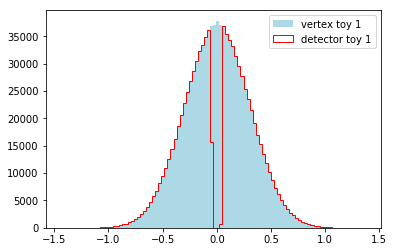

In [4]:
# -- if hole is false, then plot with zeros in the hole
plot_data(vertex, detector[:,0], hole = True)

In [5]:
# -- create the label hand assign zero if the event is missing
ones = np.ones(1000000)
ones = ones.reshape(-1,1 )

for i in range(1000000):
    if detector[i] ==0:
        ones[i] =0

In [6]:
detector = np.append(detector, ones, axis=1)
detector.shape

(1000000, 2)

In [23]:
class LSGAN():
    def __init__(self):
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

          # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
    
        self.discriminator.compile(loss=['mse'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        label = Input(shape=(1,))
        noise = Input(shape=(100,))

        img = self.generator([label, noise])
        

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image

        valid = self.discriminator(img)
        

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([label, noise], valid)
        self.combined.compile(loss=['mse'],
            optimizer=optimizer)


    def build_generator(self):
        p0 = Input(shape=(1,))
        noise = Input(shape=(100,))
        visible = concatenate([p0, noise])
        hidden1 = Dense(256)(visible)
        LR = LeakyReLU(alpha=0.2)(hidden1)
        LR = BatchNormalization(momentum=0.8)(LR)
        hidden2 = Dense(512)(LR)
        LR = LeakyReLU(alpha=0.2)(hidden2)
        LR = BatchNormalization(momentum=0.8)(LR)   
        hidden3 = Dense(1024)(LR)
        LR = LeakyReLU(alpha=0.2)(hidden3)
        LR = BatchNormalization(momentum=0.8)(LR)
        output = Dense(1)(LR)
        ar = Dense(1, activation = 'sigmoid')(LR)
        features = concatenate([output, ar])
        detector = Lambda(self.reject)(features)

        outputmerge = concatenate([p0, detector, ar])

        generator = Model(inputs=[p0, noise], outputs=[outputmerge])
        generator.summary()
        return(generator)
    
    
    def reject(self, x):
        detector = x[:, 0:1]
        ar = x[:, 1:2]

        detector = detector * ar

        return detector
    
    
    
    def feature_mul(self, x):
        
        detector = x[:, 0:1]
        ar = x[:, 1:2]
        detector = ar * detector
    
        return detector

    def build_discriminator(self):
        visible = Input(shape=(3,))
        hidden1 = Dense(512)(visible)
        LR = LeakyReLU(alpha=0.2)(hidden1)
        LR = Dropout(0.1)(LR)
        hidden2 = Dense(256)(LR)
        LR = LeakyReLU(alpha=0.2)(hidden2)
        LR = Dropout(0.1)(LR)
        output = Dense(1)(LR)

        discriminator = Model(inputs=[visible], outputs=output)
        discriminator.summary()
        return discriminator

    def train(self, epochs, batch_size=128, sample_interval=50):

        X_train = detector
        y_train = vertex
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([labels, noise])

            # Train the discriminator
            real = np.append(labels, imgs, axis = 1)
            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(real, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Condition on labels
            sampled_labels = y_train[:batch_size]
            noise = noise[:batch_size]
            #print(noise.shape)

            # Train the generator
            g_loss = self.combined.train_on_batch([sampled_labels, noise], valid)

            # Plot the progress
            
            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.sample_images(epoch)

                
    def sample_images(self, epoch):
        
   
        SAMPLE_SIZE = 100000
        # -- noise for the prediction
        noise = np.random.normal(0, 1, (SAMPLE_SIZE, 100))

        # -- true detector is a 2d array, first is events, second is the label
        true_detector = detector[0:SAMPLE_SIZE, 0]
        true_label    = detector[0:SAMPLE_SIZE, 1] 

        # -- true vertex data, normal distribution
        true_vertex   = vertex[0:SAMPLE_SIZE]

        # -- gan will return an array of three dimentions: vertex-level, detector-level, and label
        results = self.generator.predict([true_vertex, noise])
        
        
        # -- fliter data based on label
        label_filter = np.where(results[:,2] > 0.5)
        plt.hist(true_detector[true_detector!=0], bins = 100, color = 'black', label = 'detector toy 1', histtype='step')
        plt.hist(results[:,1][label_filter], histtype='step', bins = 100, color = 'red', label = 'GAN')
        plt.legend()
        plt.show()

        plt.hist(true_label, bins = 10, color = 'black', label = 'True', histtype='step')
        plt.hist(results[:,2], histtype='step', bins = 10, color = 'red', label = 'GAN')
        plt.legend()
        plt.show()
        
        
        # -- create a uniform distribution for the testing
        uniform = np.random.uniform(low = -1, high= 1, size = (SAMPLE_SIZE, 1))
        noise = np.random.normal(0, 1, [SAMPLE_SIZE, 100])
        results = gan.generator.predict([uniform, noise])

        # -- plot the uniform distribution
        plt.hist(uniform, bins = 100, color = 'lightblue', label = 'vertex toy 2')
        plt.hist(results[:,0], histtype='step', bins=100, color = 'red', label = 'GAN')
        plt.legend(['vertex toy 2', 'GAN'])
        plt.show()

        # -- plot detector level from GAN and filter based on label
        label_filter = np.where(results[:,2] > 0.5)
        plt.hist(uniform, bins = 100, color = 'lightblue', label = 'True')
        plt.hist(results[:,1][label_filter], histtype='step', bins = 100, color = 'red', label = 'GAN')
        plt.legend(loc = 'lower left')
        plt.show()

In [24]:
gan = LSGAN()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               2048      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
__________

In [27]:
gan.train(epochs=30000, batch_size=1024, sample_interval=1000)

In [10]:
# gan.generator.load_weights('ls_generator_unfolding_toy.h5')

In [15]:
SAMPLE_SIZE = 100000
# -- noise for the prediction
noise = np.random.normal(0, 1, (SAMPLE_SIZE, 100))

# -- true detector is a 2d array, first is events, second is the label
true_detector = detector[0:SAMPLE_SIZE, 0]
true_label    = detector[0:SAMPLE_SIZE, 1] 

# -- true vertex data, normal distribution
true_vertex   = vertex[0:SAMPLE_SIZE]

# -- gan will return an array of three dimentions: vertex-level, detector-level, and label
results = gan.generator.predict([true_vertex, noise])

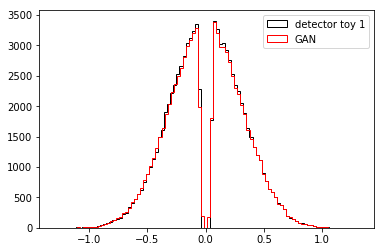

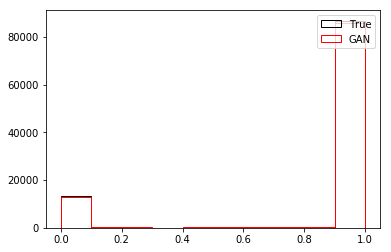

In [17]:
# -- fliter data based on label
label_filter = np.where(results[:,2] > 0.5)
plt.hist(true_detector[true_detector!=0], bins = 100, color = 'black', label = 'detector toy 1', histtype='step')
plt.hist(results[:,1][label_filter], histtype='step', bins = 100, color = 'red', label = 'GAN')
plt.legend()
plt.show()

plt.hist(true_label, bins = 10, color = 'black', label = 'True', histtype='step')
plt.hist(results[:,2], histtype='step', bins = 10, color = 'red', label = 'GAN')
plt.legend()
plt.show()

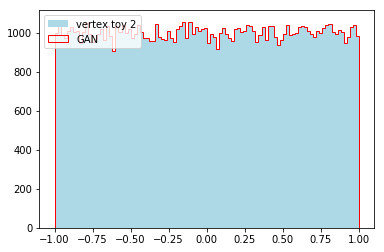

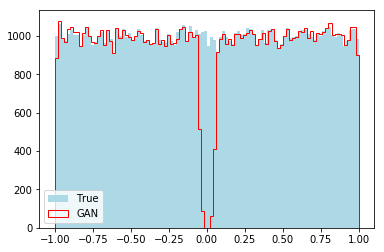

In [22]:
# -- create a uniform distribution for the testing
uniform = np.random.uniform(low = -1, high= 1, size = (SAMPLE_SIZE, 1))
noise = np.random.normal(0, 1, [SAMPLE_SIZE, 100])
results = gan.generator.predict([uniform, noise])

# -- plot the uniform distribution
plt.hist(uniform, bins = 100, color = 'lightblue', label = 'vertex toy 2')
plt.hist(results[:,0], histtype='step', bins=100, color = 'red', label = 'GAN')
plt.legend(['vertex toy 2', 'GAN'])
plt.show()

# -- plot detector level from GAN and filter based on label
label_filter = np.where(results[:,2] > 0.5)
plt.hist(uniform, bins = 100, color = 'lightblue', label = 'True')
plt.hist(results[:,1][label_filter], histtype='step', bins = 100, color = 'red', label = 'GAN')
plt.legend(loc = 'lower left')
plt.show()

In [ ]:
# # #save the weights
# gan.generator.save_weights('ls_generator_unfolding_toy.h5')
# gan.discriminator.save_weights('ls_discriminator_unfolding_toy.h5')